PRÉ PROCESSAMENTO

In [1]:
#Limpa texto bruto

import re

# Regex pré-compiladas
URL_MENCAO_REGEX = re.compile(r"http\S+|www\S+|https\S+|@\w+|#")
EMOJI_SYMBOL_REGEX = re.compile(r"[^\w\s\-áéíóúâêôãõç]", flags=re.UNICODE)

ABREVIACOES = {
    "q": "que", "pq": "porque", "vc": "você", "vcs": "vocês", "tb": "também",
    "blz": "beleza", "hj": "hoje", "amanha": "amanhã", "mt": "muito", "td": "tudo",
    "obg": "obrigado", "vlw": "valeu", "msg": "mensagem", "n": "não", "s": "sim",
    "tbm": "também", "p": "para", "nao": "não"
}
ABREVIACOES_REGEX = re.compile(r'\b(' + '|'.join(map(re.escape, ABREVIACOES.keys())) + r')\b', flags=re.IGNORECASE)

def substituir_abreviacoes(match):
    palavra = match.group(0).lower()
    return ABREVIACOES.get(palavra, palavra)

def limpar_texto_bruto(texto: str) -> str:
    texto = URL_MENCAO_REGEX.sub(" ", texto)
    texto = ABREVIACOES_REGEX.sub(substituir_abreviacoes, texto)
    texto = EMOJI_SYMBOL_REGEX.sub(" ", texto)
    return texto

def carregar_stopwords_personalizadas():
    with open('stopwords.txt', "r", encoding="utf-8") as f:
        return set(p.strip().lower() for p in f if p.strip())

In [2]:
#Configuração do spaCy e Matcher

import spacy
import nltk
from spacy.matcher import Matcher

nlp = spacy.load('pt_core_news_lg')
#stopwords = set(nltk.corpus.stopwords.words('portuguese'))
stopwords = carregar_stopwords_personalizadas()
matcher = Matcher(nlp.vocab)

# Adiciona padrões
matcher.add("NUM_UNIDADE", [[
    {"LIKE_NUM": True},
    {"LOWER": {"IN": ["mil", "milhão", "milhões", "bilhão", "bilhões"]}, "OP": "?"},
    {"LOWER": "de", "OP": "?"},
    {"POS": "NOUN"}
]])
matcher.add("SUBSTANTIVOS", [[{"POS": "NOUN"}]])
matcher.add("PROPRIOS", [[{"POS": "PROPN"}]])
matcher.add("ADJETIVOS", [[{"POS": "ADJ"}]])

In [3]:
from spacy.util import filter_spans

def capitalizar_palavras(texto):
    return ' '.join(p.capitalize() for p in texto.split())

def pre_processar_doc(doc):
    from collections import defaultdict

    matches = matcher(doc)
    spans = [doc[start:end] for _, start, end in matches]
    spans_filtrados = filter_spans(spans)

    spans_dict = {span.start: span for span in spans_filtrados}
    ent_by_start = {ent.start: ent for ent in doc.ents}

    tokens = []
    i = 0
    while i < len(doc):
        if i in ent_by_start:
            ent = ent_by_start[i]
            tokens.append(capitalizar_palavras(ent.text.lower()))
            i = ent.end
        elif i in spans_dict:
            span = spans_dict[i]
            span_text = span.text.lower()
            if len(span) == 1:
                token = span[0]
                if token.pos_ == "VERB":
                    tokens.append(token.lemma_)
                elif token.is_alpha and token.text.lower() not in stopwords and len(token.text) >= 3:
                    tokens.append(token.text.lower())
            elif len(span_text) >= 3:
                tokens.append(span_text)
            i = span.end
        else:
            i += 1

    return tokens

PROCESSAR LOTES DE TEXTOS

In [4]:
def processar_lote_textos(lista_de_textos, batch_size=1000, n_process=1):
    docs = nlp.pipe([limpar_texto_bruto(txt) for txt in lista_de_textos],
                    batch_size=batch_size,
                    n_process=n_process)
    return [pre_processar_doc(doc) for doc in docs]

CLUSTERIZAÇÃO

In [40]:
import networkx as nx
import os

def extrair_clusters_com_ramos(graphml_path):
    G = nx.read_graphml(graphml_path)
    if "0" in G:
        G.remove_node("0")

    def nome(n):
        return G.nodes[n].get("value", n)

    componentes = []
    visitados = set()

    for raiz in G.nodes:
        if raiz in visitados or G.out_degree(raiz) == 0:
            continue

        descendentes = nx.descendants(G, raiz)
        cluster_nos = {raiz} | descendentes
        if len(cluster_nos) <= 1:
            continue

        visitados |= cluster_nos

        folhas = [n for n in cluster_nos if G.out_degree(n) == 0]
        ramos = []
        palavras_ramos = set()
        for folha in folhas:
            for caminho in nx.all_simple_paths(G, raiz, folha):
                caminho_nomes = [nome(n) for n in caminho]
                ramos.append(caminho_nomes)
                palavras_ramos.update(caminho_nomes[1:])

        componentes.append({
            "raiz": nome(raiz),
            "ramos": ramos,
            "n_nos": len(cluster_nos),
            "ids": cluster_nos,
            "palavras": list(palavras_ramos)
        })

    
    #Exibir
    for idx, c in enumerate(componentes, 1):
        print(f"Cluster {idx} — Raiz: {c['raiz']} — {c['n_nos']} nós")
        print("Ramos: ")
        for ramo in c["ramos"]:
            print(" → ".join(ramo))
        print("Palavras:")
        print(", ".join(c["palavras"]))
        print("-" * 80)

    return componentes


SEPARA CLUSTERS

In [39]:
import networkx as nx
import os

def separar_clusters_por_tamanho(graphml_path, pasta_destino="outputs_clusters"):
    os.makedirs(pasta_destino, exist_ok=True)

    G = nx.read_graphml(graphml_path)
    G_pequenos = nx.DiGraph()
    G_maiores = nx.DiGraph()

    # Armazena os atributos do nó "0" e suas arestas
    origem_presente = "0" in G
    if origem_presente:
        atributos_0 = G.nodes["0"]
        arestas_de_0 = list(G.out_edges("0", data=True))
        arestas_para_0 = list(G.in_edges("0", data=True))

    for vizinho in G.successors("0") if origem_presente else G.nodes:
        if vizinho == "0":
            continue

        subnos = nx.descendants(G, vizinho) | {vizinho}
        subgrafo = G.subgraph(subnos).copy()

        if len(subgrafo.nodes) <= 1:
            G_pequenos = nx.compose(G_pequenos, subgrafo)
        else:
            G_maiores = nx.compose(G_maiores, subgrafo)

    # Adiciona "0" e suas arestas aos dois grafos se necessário
    if origem_presente:
        for G_cluster in [G_pequenos, G_maiores]:
            G_cluster.add_node("0", **atributos_0)
            for u, v, data in arestas_de_0:
                if v in G_cluster:
                    G_cluster.add_edge(u, v, **data)
            for u, v, data in arestas_para_0:
                if u in G_cluster:
                    G_cluster.add_edge(u, v, **data)

    # Salva os arquivos
    path_pequenos = os.path.join(pasta_destino, "clusters_pequenos.graphml")
    path_maiores = os.path.join(pasta_destino, "clusters_maiores.graphml")
    nx.write_graphml(G_pequenos, path_pequenos)
    nx.write_graphml(G_maiores, path_maiores)

    return path_pequenos, path_maiores


TWEETS MAIS RELEVANTES

In [7]:
def encontrar_tweets_relacionados(componentes, textos_tokenizados, textos_originais):
    resultados = []

    for idx, c in enumerate(componentes, 1):
        ramos_sets = [set(r) for r in c["ramos"]]
        tweets_relevantes = []

        for i, tokens in enumerate(textos_tokenizados):
            tokens_set = set(tokens)
            if any(ramo.issubset(tokens_set) for ramo in ramos_sets):
                tweets_relevantes.append({
                    "tweet": textos_originais[i],
                    "index": i
                })

        resultados.append({
            "cluster_idx": idx,
            "raiz": c["raiz"],
            "n_nos": c["n_nos"],
            "n_tweets": len(tweets_relevantes),
            "tweets": tweets_relevantes
        })

        print(f"Cluster {idx} ({c['raiz']}) — {len(tweets_relevantes)} tweets relacionados")

    return resultados


CONSULTA IA PARA RESUMIR TWEETS

In [63]:
from openai import OpenAI
import os
from dotenv import load_dotenv

load_dotenv(dotenv_path="variables.env")

api_key = os.environ.get("API_KEY")

client = OpenAI(api_key=api_key)

def consult_IA(promp):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "user", "content": promp}
        ],
        temperature=1,
        max_tokens=2048,
        top_p=1
    )

    print(response.choices[0].message.content)

In [8]:
def gera_prompt(c):
    prompt = f"Considere os tweets a seguir, que foram identificados como relacionados ao assunto {c['raiz']}. Eles mencionam com frequência palavras como: {', '.join(c['palavras'])}. Com base nesse conteúdo, gere um pequeno texto de 1 a 2 parágrafos, com uma síntese clara e objetiva sobre o que está sendo discutido nos tweets. O texto deve ajudar qualquer pessoa a entender rapidamente o teor das conversas, mesmo que ela não tenha lido os tweets originais. Retorne somente o resumo."
    return prompt
    #return consult_IA(prompt)

CONTAGEM DE PALAVRAS

In [9]:
from collections import Counter
import csv

def contagem_palavras(list):

    contador = Counter()
    for sublist in list:
        contador.update(sublist)

    mais_comuns = contador.most_common(1000)
    
    with open("frequencia_palavras.csv", mode="w", newline="", encoding="utf-8") as arquivo_csv:
        writer = csv.writer(arquivo_csv)
        writer.writerows(mais_comuns)

MAIN

In [32]:
import pandas as pd
from trieofrules import trieofrules

# 1. Carrega o CSV
print("Carregando dataset...")
df = pd.read_csv("datasets/tweets_jun_2025.csv")
lista_de_textos = df["description"].astype(str).tolist()

# 2. Pré-processamento
print("Pré-processando textos com spaCy...")
resultado = processar_lote_textos(lista_de_textos, batch_size=1000, n_process=1)


Carregando dataset...
Pré-processando textos com spaCy...


In [33]:
contagem_palavras(resultado)

Gerando árvore de regras (TOR)...
Salvando .graphml...


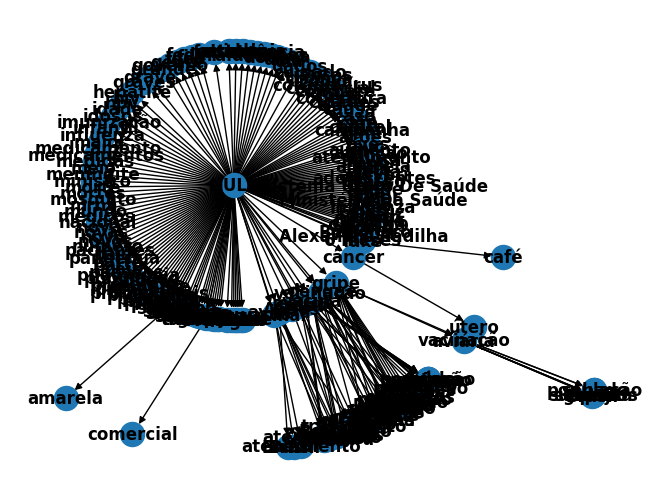

In [34]:
# 3. Gera o TOR (Trie of Rules) a partir dos dados
print("Gerando árvore de regras (TOR)...")
TOR = trieofrules(data=resultado, alg='Apriori', min_support=0.008)
TOR.draw()

# 4. Salva a visualização e estrutura como .graphml
print("Salvando .graphml...")
TOR.save_graph(filename="outputs/semana_1_jun_2025.graphml")

In [51]:
# 5. Extrai clusters com ramos hierárquicos
print("Extraindo clusters e ramos do grafo...")
path_file = "outputs/jun_2025.graphml"
componentes = extrair_clusters_com_ramos(path_file)
separar_clusters_por_tamanho(path_file)

Extraindo clusters e ramos do grafo...
Cluster 1 — Raiz: Aedes — 2 nós
Ramos: 
Aedes → aegypti
Palavras:
aegypti
--------------------------------------------------------------------------------
Cluster 2 — Raiz: Brasil — 2 nós
Ramos: 
Brasil → casos
Palavras:
casos
--------------------------------------------------------------------------------
Cluster 3 — Raiz: aviária — 7 nós
Ramos: 
aviária → suspeita
aviária → casos
aviária → Brasil
aviária → suspeitos
aviária → granja
aviária → aves
Palavras:
granja, Brasil, suspeita, suspeitos, aves, casos
--------------------------------------------------------------------------------
Cluster 4 — Raiz: casos — 4 nós
Ramos: 
casos → aumento
casos → doença
casos → Covid-19
Palavras:
Covid-19, doença, aumento
--------------------------------------------------------------------------------
Cluster 5 — Raiz: câncer — 2 nós
Ramos: 
câncer → útero
Palavras:
útero
--------------------------------------------------------------------------------
Cluster 6

('outputs_clusters\\clusters_pequenos.graphml',
 'outputs_clusters\\clusters_maiores.graphml')

In [42]:
import os

pasta = "outputs_clusters_csv"
os.makedirs(pasta, exist_ok=True)

# 6. Relaciona tweets aos clusters
print("Relacionando tweets aos clusters...")
relacionados = encontrar_tweets_relacionados(componentes, resultado, lista_de_textos)

# 7. (Opcional) Salva tweets relacionados por cluster
print("Salvando resultados...")
for c in relacionados:
    if c["n_tweets"] == 0:
        continue
    nome = c["raiz"].replace(" ", "_")[:30]
    df_cluster = pd.DataFrame(c["tweets"])
    caminho = os.path.join(pasta, f"tweets_cluster_{c['cluster_idx']}_{nome}.csv")
    df_cluster.to_csv(caminho, index=False)

print("✅ Pipeline finalizado com sucesso.")


Relacionando tweets aos clusters...
Cluster 1 (Bolsonaro) — 5 tweets relacionados
Cluster 2 (Brasil) — 19 tweets relacionados
Cluster 3 (Covid) — 1 tweets relacionados
Cluster 4 (casos) — 13 tweets relacionados
Cluster 5 (crianças) — 18 tweets relacionados
Cluster 6 (dengue) — 48 tweets relacionados
Cluster 7 (dose) — 10 tweets relacionados
Cluster 8 (febre) — 12 tweets relacionados
Cluster 9 (gripe) — 157 tweets relacionados
Cluster 10 (grupos) — 5 tweets relacionados
Cluster 11 (mortes) — 1 tweets relacionados
Cluster 12 (proteína) — 2 tweets relacionados
Cluster 13 (reações) — 5 tweets relacionados
Cluster 14 (redução) — 2 tweets relacionados
Cluster 15 (saúde) — 61 tweets relacionados
Cluster 16 (sábado) — 8 tweets relacionados
Cluster 17 (terapia) — 6 tweets relacionados
Cluster 18 (vacina) — 207 tweets relacionados
Cluster 19 (vacinal) — 11 tweets relacionados
Cluster 20 (vacinas) — 14 tweets relacionados
Cluster 21 (vacinação) — 133 tweets relacionados
Salvando resultados...
✅ P

In [38]:
print(gera_prompt(componentes[5]))

Considere os tweets a seguir, que foram identificados como relacionados ao assunto saúde. Eles mencionam com frequência palavras como: profissionais, crianças, sus, pública. Com base nesse conteúdo, gere um pequeno texto de 1 a 2 parágrafos, com uma síntese clara e objetiva sobre o que está sendo discutido nos tweets. O texto deve ajudar qualquer pessoa a entender rapidamente o teor das conversas, mesmo que ela não tenha lido os tweets originais. Retorne somente o resumo.


In [48]:
txt = ["@efarsas kkkkkkkk Certíssimo. Mesmo pq a epidemia de avc, infartos, mortes súbitas e canceres turbo são causados pelas mudanças climáticas. A vacina feita em menos de 6 meses não tem nada a ver com isso."]
result = processar_lote_textos(txt)
print(result)

[['kkkkkkkk', 'certíssimo', 'epidemia', 'avc', 'infartos', 'mortes', 'súbitas', 'canceres', 'mudanças', 'climáticas', 'vacina', '6 meses']]
